In [1]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import math
from astropy import time, coordinates as coord, units as u
import requests
import matplotlib.dates as mdates
from pandas.plotting import table

Path to PixInsight photometry result files

In [3]:
target="W UMa"
path="D:\\Astronomie\\SharpCap Captures\\20250309\\WUma\\work\\photometry"
filelist=os.listdir(path)

Get AAVSO data from target variable

In [4]:
response = requests.get(f"http://www.aavso.org/vsx/index.php?view=api.object&ident={target}&format=json")   
vsx_data=response.json()['VSXObject']
vsx_data

{'Name': 'W UMa',
 'AUID': '000-BBQ-676',
 'RA2000': '145.93946',
 'Declination2000': '55.95253',
 'ProperMotionRA': '17.2400',
 'ProperMotionDec': '-28.9100',
 'VariabilityType': 'EW/KW',
 'Period': '0.3336334',
 'Epoch': '2453761.977',
 'MaxMag': '7.75 V',
 'MinMag': '8.48 V',
 'SpectralType': 'F8Vp+F8Vp',
 'Discoverer': 'Müller and Kempf (1908)',
 'Category': 'Variable',
 'OID': '37110',
 'Constellation': 'UMa'}

In [5]:
constellation=vsx_data['Constellation']
star=vsx_data['Name']
period= vsx_data['Period']
position = coord.SkyCoord(vsx_data['RA2000'],vsx_data['Declination2000'],
                        unit=(u.deg, u.deg), frame='icrs')
observatory = coord.EarthLocation(lat=51.43, lon=6.82, height=40)

Get Photometry field from AAVSO

In [6]:
response = requests.get(f"https://www.aavso.org/vsp/api/chart/?star={star}&fov=60&maglimit=15&format=json")
chart_data=response.json()
chart_data

{'chartid': 'X40024I',
 'image_uri': 'https://apps.aavso.org/vsp/chart/X40024I.png?format=json',
 'star': 'W UMa',
 'fov': 60.0,
 'maglimit': 15.0,
 'title': '',
 'comment': '',
 'resolution': 150,
 'dss': False,
 'special': None,
 'photometry': [{'auid': '000-BBQ-651',
   'ra': '09:42:42.03',
   'dec': '55:39:56.3',
   'label': '89',
   'bands': [{'band': 'V', 'mag': 8.936, 'error': 0.052},
    {'band': 'B', 'mag': 9.81, 'error': 0.066},
    {'band': 'Ic', 'mag': 7.909, 'error': 0.082},
    {'band': 'J', 'mag': 7.242, 'error': 0.017},
    {'band': 'H', 'mag': 6.802, 'error': 0.011},
    {'band': 'K', 'mag': 6.71, 'error': 0.013}],
   'comments': ''},
  {'auid': '000-BBQ-747',
   'ra': '09:46:02.66',
   'dec': '55:45:00.0',
   'label': '92',
   'bands': [{'band': 'V', 'mag': 9.161, 'error': 0.049},
    {'band': 'B', 'mag': 10.342, 'error': 0.067},
    {'band': 'Ic', 'mag': 7.913, 'error': 0.076},
    {'band': 'J', 'mag': 7.118, 'error': 0.021},
    {'band': 'H', 'mag': 6.566, 'error': 

In [7]:
auid_list = []
for photometry_data in chart_data['photometry']:
    auid = photometry_data['auid']
    ra=photometry_data['ra']
    dec=photometry_data['dec']
    for band_data in photometry_data['bands']:
        if band_data['band'] == 'V':
            mag = band_data['mag']
            auid_list.append((auid, ra, dec, mag))

In [8]:
auid_list

[('000-BBQ-651', '09:42:42.03', '55:39:56.3', 8.936),
 ('000-BBQ-747', '09:46:02.66', '55:45:00.0', 9.161)]

Match with PixInsight Photometry Table

In [9]:
file=filelist[0]
df=pd.read_csv(path+"\\"+file,sep=";",skiprows=5)
df.columns = df.columns.str.replace(' ', '')
names= df[['NAME']].to_numpy()
catalogue= df[['CATRA', 'CATDEC']].to_numpy()
flags= df[['FLAG']].to_numpy() 
catalogue=coord.SkyCoord(catalogue[:,0],catalogue[:,1],unit=(u.deg, u.deg), frame='icrs')

In [10]:
idx,d2d,d3d=position.match_to_catalog_sky(catalogue)
varstar=names[idx][0].replace(" ", "")
varstar

'3UCAC292-105168'

In [12]:
star_data=np.array([(tup[1], tup[2]) for tup in auid_list])
star_coord=coord.SkyCoord(star_data[:,0],star_data[:,1],unit=(u.hourangle, u.deg), frame='icrs')

In [13]:
idx,d2d,d3d=star_coord.match_to_catalog_sky(catalogue)

In [14]:
d2d

<Angle [0.00076495, 0.00013752] deg>

In [15]:
df.iloc[idx]

,DATE_OBS,NAME,FILTER,CATRA,CATDEC,IMGRA,IMGDEC,IMGX,IMGY,f.mag,...,SNR10,SNR11,SNR12,SNR13,SNR14,SNR15,SNR16,SNR17,SNR18,FLAG
3,2.460738e+06,3UCAC292-105134,Johnson V,145.674761,55.664902,145.674755,55.664889,2952.439,547.458,8.493,...,558.2073,556.1089,551.9038,546.4157,539.9693,532.9556,525.5048,517.7928,509.8250,0
5,2.460738e+06,3UCAC292-105240,Johnson V,146.510994,55.749872,146.510944,55.749856,3816.904,2362.698,8.652,...,516.0040,512.5787,507.5967,501.5795,494.9387,487.6977,480.0323,472.1017,464.0666,0


In [20]:
photometry_stars=[]
photometry_mags=[]
for i in range(len(auid_list)):
    if flags[idx[i]] == 0 and d2d[i].arcsec < 10.0:
        photometry_stars.append(names[idx[i]][0].replace(" ", ""))
        photometry_mags.append(auid_list[i][3])

In [21]:
photometry_stars, photometry_mags

(['3UCAC292-105134', '3UCAC292-105240'], [8.936, 9.161])

In [64]:

check=photometry_stars[0]
compstar=photometry_stars[1:2]
compstar_mag=photometry_mags[1:2]

In [65]:
check

'3UCAC292-105134'

In [66]:
file=filelist[0]
df=pd.read_csv(path+"\\"+file,sep=";",skiprows=5)
df

,DATE_OBS,NAME,FILTER,CATRA,CATDEC,IMGRA,IMGDEC,IMGX,IMGY,f.mag,...,SNR10,SNR11,SNR12,SNR13,SNR14,SNR15,SNR16,SNR17,SNR18,FLAG
0,2.460738e+06,3UCAC292-105088,Johnson V,145.319330,55.866243,145.319347,55.866246,1774.225,368.890,6.319,...,1709.8250,1724.6650,1733.3540,1738.2940,1740.8820,1741.6460,1741.2880,1740.0330,1738.0800,10
1,2.460738e+06,3UCAC292-105167,Johnson V,145.939380,55.952130,145.939661,55.952317,2341.641,1761.961,7.600,...,897.3200,900.3655,900.6214,899.2033,896.7728,893.4697,889.4042,884.7583,879.6403,1
2,2.460738e+06,3UCAC292-105168,Johnson V,145.939864,55.952429,145.939661,55.952317,2341.641,1761.961,8.324,...,897.3200,900.3655,900.6214,899.2033,896.7728,893.4697,889.4042,884.7583,879.6403,1
3,2.460738e+06,3UCAC292-105134,Johnson V,145.674761,55.664902,145.674755,55.664889,2952.439,547.458,8.493,...,558.2073,556.1089,551.9038,546.4157,539.9693,532.9556,525.5048,517.7928,509.8250,0
4,2.460738e+06,3UCAC293-109009,Johnson V,145.621195,56.187249,145.621208,56.187240,1104.692,1736.808,8.507,...,575.7884,574.0490,570.1944,564.9670,558.7805,551.9471,544.4825,536.6611,528.7717,0
5,2.460738e+06,3UCAC292-105240,Johnson V,146.510994,55.749872,146.510944,55.749856,3816.904,2362.698,8.652,...,516.0040,512.5787,507.5967,501.5795,494.9387,487.6977,480.0323,472.1017,464.0666,0
6,2.460738e+06,3UCAC292-105289,Johnson V,146.803479,55.812654,146.803459,55.812643,4000.777,3080.045,9.535,...,328.6112,322.5532,315.7867,308.5743,301.0845,293.2643,285.4338,277.7457,270.1175,0


In [67]:
t0=df.iloc[0,0]
t0_iso=time.Time(t0,format="jd")

In [69]:
l=[]
for s in df.iloc[:,1]: l=l+[s.strip()]
df.iloc[:,1]=l

In [70]:
def snrlst(target,infiles):
    target_snr=[]
    for file in infiles:
        df=pd.read_csv(path+"\\"+file,sep=";",skiprows=5)
         #find target star
        l=[]
        for s in df.iloc[:,1]: l=l+[s.strip()]
        df.iloc[:,1]=l
        itarget=(df.iloc[:,1]==target)
        target_snr=target_snr+[df.loc[itarget]]
    target_snr=pd.concat(target_snr,ignore_index=True)
    ind=[]
    col=target_snr.columns.to_list()
    for s in col:
        ind = ind + [s.startswith("SNR")]
    target_snr=target_snr.loc[:,ind]
    return target_snr.mean()

In [71]:
snr=snrlst(varstar,filelist)
snrmax=snr.idxmax()
labelflux=snrmax.replace("SNR","FLUX")
labelflux

'FLUX11   '

In [72]:
def fluxcalc2(target,infiles,label_max):
    target_flux=pd.DataFrame()
    for file in infiles:
        #read file
        df=pd.read_csv(path+"\\"+file,sep=";",skiprows=5)
        #find target star
        l=[]
        for s in df.iloc[:,1]: l=l+[s.strip()]
        df.iloc[:,1]=l
        itarget=(df.iloc[:,1]==target)
        #read flux
        flux=df.loc[itarget][['DATE_OBS     ',label_max]]
        flux=flux.rename(columns={'DATE_OBS     ':"DATE_OBS",label_max:"FLUX"})
        target_flux=pd.concat([target_flux,flux])
    target_flux=target_flux.reset_index(drop=True)
    return target_flux

In [73]:
minind=0
maxind=len(filelist)

In [74]:
flux_var=fluxcalc2(varstar,filelist,labelflux)
flux_check=fluxcalc2(check,filelist,labelflux)

In [75]:
flux_comp=pd.DataFrame()
flux_comp["DATE_OBS"]=flux_var["DATE_OBS"]
flux_comp=flux_comp.reset_index(drop=True)
for star in compstar:
    flux=fluxcalc2(star,filelist,labelflux)
    #flux = flux.reset_index(drop=True)
    flux_comp[star]=flux['FLUX']
print(flux_comp)   

         DATE_OBS  3UCAC292-105240
0    2.460738e+06        316486.77
1    2.460738e+06        315679.42
2    2.460738e+06        329536.27
3    2.460738e+06        341920.57
4    2.460738e+06        331694.46
..            ...              ...
133  2.460739e+06        173727.68
134  2.460739e+06        173049.02
135  2.460739e+06        177503.55
136  2.460739e+06        172515.57
137  2.460739e+06        169678.97

[138 rows x 2 columns]


In [76]:
t=flux_var.to_numpy()[minind:maxind,0]
mag_var=flux_var.to_numpy()[minind:maxind,1]
mag_check=flux_check.to_numpy()[minind:maxind,1]
mag_comp=flux_comp.to_numpy()[minind:maxind,1:]

In [77]:
nstars = mag_comp.shape[1]+2
nstars

3

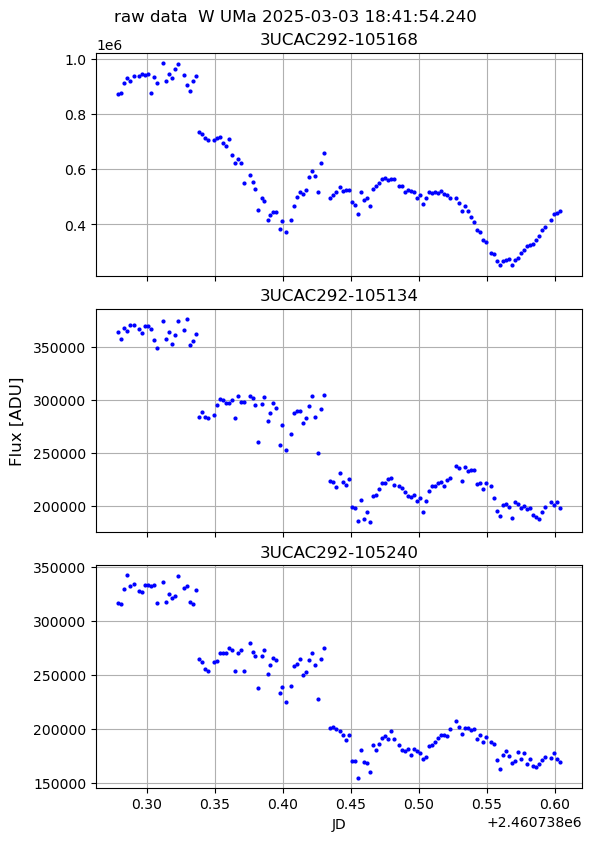

In [78]:
fig, ax = plt.subplots(nstars,1,figsize=(5.8,8.3), layout='constrained')
fig.suptitle("raw data " + " " + target + " " + t0_iso.iso )
fig.supylabel("Flux [ADU]")
ax[0].plot(t,mag_var,"bo",ms=2)
ax[0].set_title(varstar)
ax[0].tick_params(axis="x",labelbottom=False)
ax[0].grid(visible="true")
ax[1].plot(t,mag_check,"bo",ms=2)
ax[1].set_title(check)
ax[1].grid(visible="true")
ax[1].tick_params(axis="x",labelbottom=False)
for i in range(2,nstars):
    ax[i].plot(t,mag_comp[:,i-2],"bo",ms=2)
    ax[i].set_title(compstar[i-2])
    ax[i].grid(visible="true")
    ax[i].tick_params(axis="x",labelbottom=False)
ax[nstars-1].set_xlabel("JD")
ax[nstars-1].tick_params(axis="x",labelbottom=True)

fig.savefig(constellation+"_"+target.replace(constellation, "")+"_"+'%-8.4f'%(t0_iso.to_value("jd")-2400000)+"_"+"RAW_DATA"+".pdf", format="pdf")

In [79]:
# Create a new DataFrame with the same column names as flux_comp
mag_var = pd.DataFrame({'DATE_OBS': flux_comp['DATE_OBS']})

# Calculate the new columns
for star, mag0 in zip(compstar, compstar_mag):
    mag_var[star] = -2.5 * np.log10(flux_var['FLUX'] / flux_comp[star]) + mag0

print(mag_var)

         DATE_OBS  3UCAC292-105240
0    2.460738e+06         8.061939
1    2.460738e+06         8.052042
2    2.460738e+06         8.055879
3    2.460738e+06         8.074743
4    2.460738e+06         8.055224
..            ...              ...
133  2.460739e+06         8.285484
134  2.460739e+06         8.209068
135  2.460739e+06         8.182118
136  2.460739e+06         8.137977
137  2.460739e+06         8.103068

[138 rows x 2 columns]


In [81]:
# Identify the columns to be averaged (all columns except 'date_obs')
columns_to_average = mag_var.columns.difference(['DATE_OBS'])

# Calculate the row-wise mean for these columns
mag_var['average'] = mag_var[columns_to_average].mean(axis=1)

mag_var

,DATE_OBS,3UCAC292-105240,average
0,2.460738e+06,8.061939,8.061939
1,2.460738e+06,8.052042,8.052042
2,2.460738e+06,8.055879,8.055879
3,2.460738e+06,8.074743,8.074743
4,2.460738e+06,8.055224,8.055224
...,...,...,...
133,2.460739e+06,8.285484,8.285484
134,2.460739e+06,8.209068,8.209068
135,2.460739e+06,8.182118,8.182118
136,2.460739e+06,8.137977,8.137977


In [82]:
mag = mag_var['average'].to_numpy()
mag.shape

(138,)

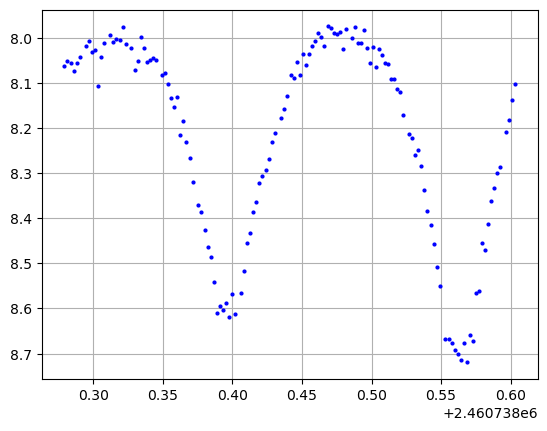

In [83]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(t,mag,"bo",ms=2)  # Plot some data on the axes.
#ax.set_ylim(12.7,12.8)
ax.invert_yaxis()
ax.grid(visible=True)

In [84]:
# Create a new DataFrame with the same column names as flux_comp
mag_check = pd.DataFrame({'DATE_OBS': flux_comp['DATE_OBS']})

# Calculate the new columns
for star, mag0 in zip(compstar, compstar_mag):
    mag_check[star] = -2.5 * np.log10(flux_check['FLUX'] / flux_comp[star]) + mag0

print(mag_check)

         DATE_OBS  3UCAC292-105240
0    2.460738e+06         9.008447
1    2.460738e+06         9.024365
2    2.460738e+06         9.042019
3    2.460738e+06         9.089042
4    2.460738e+06         9.040346
..            ...              ...
133  2.460739e+06         9.012992
134  2.460739e+06         8.981029
135  2.460739e+06         9.023474
136  2.460739e+06         8.980737
137  2.460739e+06         8.993448

[138 rows x 2 columns]


In [85]:
# Identify the columns to be averaged (all columns except 'date_obs')
columns_to_average = mag_check.columns.difference(['DATE_OBS'])

# Calculate the row-wise mean for these columns
mag_check['average'] = mag_check[columns_to_average].mean(axis=1)

mag_check

,DATE_OBS,3UCAC292-105240,average
0,2.460738e+06,9.008447,9.008447
1,2.460738e+06,9.024365,9.024365
2,2.460738e+06,9.042019,9.042019
3,2.460738e+06,9.089042,9.089042
4,2.460738e+06,9.040346,9.040346
...,...,...,...
133,2.460739e+06,9.012992,9.012992
134,2.460739e+06,8.981029,8.981029
135,2.460739e+06,9.023474,9.023474
136,2.460739e+06,8.980737,8.980737


In [86]:
mag_c = mag_check['average'].to_numpy()
mag.shape

(138,)

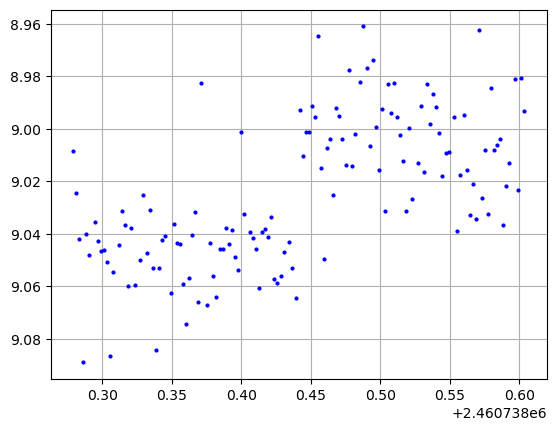

In [87]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(t,mag_c,"bo",ms=2)  # Plot some data on the axes.
ax.grid(visible=True)
#ax.set_ylim(12.4,12.5)
ax.invert_yaxis()

In [88]:
err_c=np.std(mag_c)
err_c

0.02781785002158265

In [44]:
lc=np.empty((mag.shape[0],3))
lc[:,0]=t
lc[:,1]=mag
lc[:,2]=err_c

In [45]:
t0=int(lc[0,0])
t=lc[:,0]-t0
mag=lc[:,1]
merr=lc[:,2]

In [46]:
t0_ap=time.Time(t0,format="jd")
t0_ap.to_value("iso",subfmt="date")

'2025-03-03'

In [47]:
p=float(period)
w=2*math.pi/p
k=8
C=np.stack([np.sin(i*w*t) for i in range(1,k+1)])
B=np.stack([np.cos(i*w*t) for i in range(k+1)])
A=np.concatenate((B,C)).T
coeff = np.linalg.lstsq(A,mag,rcond=None)[0]

In [48]:
def lc_fourier(t,w,coeff):
    n=coeff.shape[0]
    mag=0
    k=int((n-1)/2)
    for i in range(0,k+1):
        mag=mag+coeff[i]*np.cos(i*w*t)
    for i in range(k+1,n):
        mag=mag+coeff[i]*np.sin((i-k)*w*t)
    return mag

In [49]:
t_step=np.linspace(min(t),max(t),1000)

In [50]:
x=lc_fourier(t_step,w,coeff)

In [51]:
ind=sp.signal.argrelmin(x)
ind1=sp.signal.argrelmax(x)

In [52]:
ind1

(array([106, 362, 875], dtype=int64),)

In [53]:
t0_ap=time.Time(t0+t_step[ind],format="jd")
t1_ap=time.Time(t0+t_step[ind1],format="jd")
t0_ap.to_value("iso")

array(['2025-03-03 19:22:06.256', '2025-03-03 19:48:16.872',
       '2025-03-03 23:16:45.701'], dtype='<U23')

In [54]:
t0_ap = time.Time(t0+t_step[ind],format="jd",
                  scale='utc', location=observatory)  
t1_ap=time.Time(t0+t_step[ind1],format="jd",
                  scale="utc",location=observatory)
ltt0_helio = t0_ap.light_travel_time(position,"heliocentric") 
ltt1_helio = t1_ap.light_travel_time(position,"heliocentric") 
ltt0_helio.to_value("jd") 

array([0.00356832, 0.00356751, 0.00356103])

In [55]:
time.Time(t0+t_step[ind],format="jd",
                  scale='utc', location=observatory)  

<Time object: scale='utc' format='jd' value=[2460738.30701686 2460738.32519528 2460738.46997339]>

In [56]:
t_am=time.Time(t0+t_step,format="jd",scale="utc",location=observatory)
frame=coord.AltAz(obstime=t_am,location=observatory)
airmass=position.transform_to(frame).secz
[airmass[0],airmass[999],np.min(airmass)]

[<Quantity 1.19607113>, <Quantity 1.21470464>, <Quantity 1.00296598>]

In [57]:
description=[["Maximum (UTC, geocentric)",t0_ap[0].to_value("iso")],
             ["Maximum (HJD, time base UTC)",'%-8.4f'%(t0_ap[0].to_value("jd")+ltt0_helio[0].to_value("jd"))+"+/-0.002"],
             ["Maximum (UTC, geocentric)",t0_ap[1].to_value("iso")],
             ["Maximum (HJD, time base UTC)",'%-8.4f'%(t0_ap[1].to_value("jd")+ltt0_helio[1].to_value("jd"))+"+/-0.002"],
             ["Minimum (UTC, geocentric)",t1_ap[0].to_value("iso")],
             ["Minimim (HJD, time base UTC)",'%-8.4f'%(t1_ap[0].to_value("jd")+ltt1_helio[0].to_value("jd"))+"+/-0.002"],
             ["Minimum (UTC, geocentric)",t1_ap[1].to_value("iso")],
             ["Minimim (HJD, time base UTC)",'%-8.4f'%(t1_ap[1].to_value("jd")+ltt1_helio[1].to_value("jd"))+"+/-0.002"],
             ["Observer","Deeskow, DES"],
             ["Instrumnent","CFF140 f/6.6, ASI1600mm with V Filter"],
             ["Comparison Star",compstar[0]],
             ["",compstar[1]],
             ["",compstar[2]],
             ["Photometry","PixInsight Photometry Skript"],
             ["Evaluation","Fourier-Fit"],
             ["Airmass","1.072 ... 1.028 ... 1.174"],
             ["Number of Measurements",str(lc.shape[0])]
            ]
title=target + " " + "             "+t0_ap[0].to_value("iso",subfmt="date")

IndexError: list index out of range

In [58]:
tiso=time.Time(t0+t,format="jd")
t_step_iso=time.Time(t0+t_step,format="jd")
jd0=t_step_iso[0].jd

In [59]:
mpl0=mpl.dates.date2num(t_step_iso[0].datetime)

In [60]:
def jd2mpl(tin):
    tout=tin+mpl0-jd0-ltt0_helio[0].to_value("jd")+int(jd0)
    return tout

In [61]:
def mpl2jd(tin):
    tout=tin-mpl0+jd0+ltt0_helio[0].to_value("jd")-int(jd0) 
    return tout

NameError: name 'title' is not defined

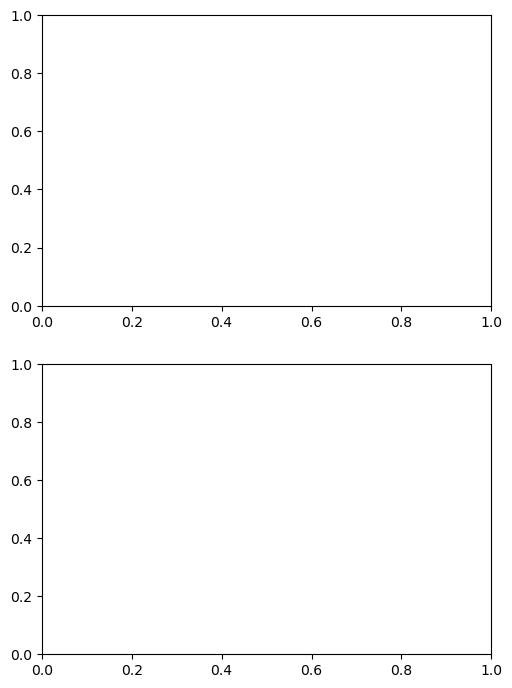

In [62]:
fig, (ax,ax1) = plt.subplots(2,1,height_ratios=[1,1],figsize=(5.8,8.3))
fig.suptitle(title,x=0.5,y=0.97,ha="center")
ax.clear()
ax.errorbar(tiso.datetime,mag,yerr=merr,elinewidth=0.5,marker="o",ms=2,linestyle="none")
ax.plot(t_step_iso.datetime,lc_fourier(t_step,w,coeff),"b--",linewidth=1)  
for i in ind[0]:
    ax.axvline(t_step_iso[i].datetime,0,1,color='dimgrey',ls="--")
for i in ind1[0]:
    ax.axvline(t_step_iso[i].datetime,0,1,color='dimgrey',ls="--")
ax.invert_yaxis()
ax.minorticks_on()
ax.grid(visible=True,which="both")
ax.set_xlabel("UTC")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#ax.set_xlabel("JD "+'%-8.0f'%(int(t0_ap.to_value("jd"))))
ax.set_ylabel("Magnitude")

secax = ax.secondary_xaxis('top', functions=(mpl2jd,jd2mpl))
secax.set_xlabel('HJD'+" "+str(int(jd0))+" +")
#pticks=ax.get_xticks()
#secax.set_xticks(mpl2jd(pticks))
secax.minorticks_on()

ax1.tick_params(
    axis="both",
    which="both",
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labeltop=False,
    labelleft=False,
    labelright=False)
ax1.set_axis_off()
ax1.table(description,loc="upper center",cellLoc="left",edges="")

fig.savefig(constellation+"_"+target.replace(constellation, "")+"_"+'%-8.4f'%(t0_ap[1].jd-2400000+ltt0_helio[1].to_value("jd"))+"_"+"DES"+".pdf", format="pdf")
    

NameError: name 'title' is not defined

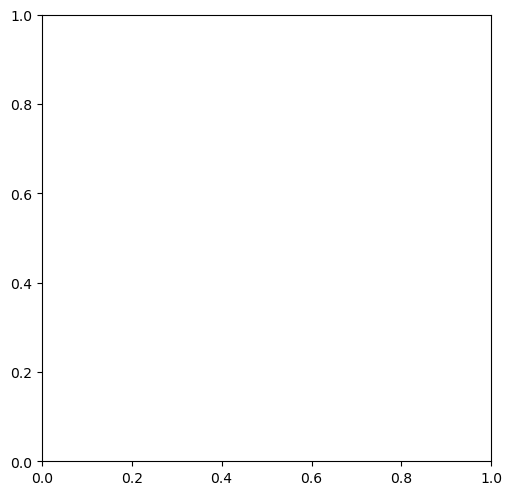

In [63]:
fig, ax = plt.subplots(1,1,height_ratios=[1],figsize=(5.8,5.8))
fig.suptitle(title,x=0.5,y=0.97,ha="center")
ax.clear()
ax.errorbar(tiso.datetime,mag,yerr=merr,elinewidth=0.5,marker="o",ms=2,linestyle="none")
ax.plot(t_step_iso.datetime,lc_fourier(t_step,w,coeff),"b--",linewidth=1)  
for i in ind[0]:
    ax.axvline(t_step_iso[i].datetime,0,1,color='dimgrey',ls="--")
for i in ind1[0]:
    ax.axvline(t_step_iso[i].datetime,0,1,color='dimgrey',ls="--")
ax.invert_yaxis()
ax.minorticks_on()
ax.grid(visible=True,which="both")
ax.set_xlabel("UTC")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#ax.set_xlabel("JD "+'%-8.0f'%(int(t0_ap.to_value("jd"))))
ax.set_ylabel("Magnitude")

secax = ax.secondary_xaxis('top', functions=(mpl2jd,jd2mpl))
secax.set_xlabel('HJD'+" "+str(int(jd0))+" +")
#pticks=ax.get_xticks()
#secax.set_xticks(mpl2jd(pticks))
secax.minorticks_on()


fig.savefig(constellation+"_"+target.replace(constellation, "")+"_"+'%-8.4f'%(t0_ap[1].jd-2400000+ltt0_helio[1].to_value("jd"))+"_"+"DES"+".png", format="png")
    

In [84]:
maxlist=[]
for i in range(t0_ap.shape[0]): 
    maximum=[constellation,
         target.replace(constellation, ""),
         "max",
         '%-8.4f'%(t0_ap[i].to_value("jd")),
         '%-8.4f'%(t0_ap[i].to_value("jd")+ltt0_helio[i].to_value("jd")),
         '0.002',
         "na",
         "na",
         '%-6.3f'%(lc_fourier(t0_ap[i].jd-t0,w,coeff)),
         "C",
         "ASI1600MM",
         "V",
         str(lc.shape[0]),
         "DES",
         "na"
        ]
    maxout=""
    for entry in maximum:
        maxout=maxout+entry+"|"
    maxlist=maxlist+[maxout]   
        
maxlist

['Cep|RZ |max|2460574.4873|2460574.4896|0.002|na|na|9.205 |C|ASI1600MM|V|302|DES|na|',
 'Cep|RZ |max|2460574.5164|2460574.5186|0.002|na|na|9.182 |C|ASI1600MM|V|302|DES|na|']

In [85]:
minlist=[]
for i in range(t1_ap.shape[0]):
    minimum=[constellation,
         target.replace(constellation, ""),
         "min",
         '%-8.4f'%(t1_ap[i].to_value("jd")),
         '%-8.4f'%(t1_ap[i].to_value("jd")+ltt1_helio[i].to_value("jd")),
         '0.002',
         "na",
         "na",
         '%-6.3f'%(lc_fourier(t1_ap[i].jd-t0,w,coeff)),
         "C",
         "ASI1600MM",
         "V",
         str(lc.shape[0]),
         "DES",
         "na"
        ]
    minout=""
    for entry in minimum:
        minout=minout+entry+"|"
    minlist=minlist+[minout]  
minlist

['Cep|RZ |min|2460574.3900|2460574.3923|0.002|na|na|9.720 |C|ASI1600MM|V|302|DES|na|',
 'Cep|RZ |min|2460574.4954|2460574.4977|0.002|na|na|9.207 |C|ASI1600MM|V|302|DES|na|']

In [86]:
f=open(constellation+"_"+target.replace(constellation, "")+"_"+'%-8.4f'%(t0_ap[i].jd-2400000+ltt0_helio[i].to_value("jd"))+"_"+"DES"+"_MiniMax"+".txt","w")
f.write("#TYPE=BAVMiniMax")
f.write("\n")
f.write("#Delim=|")
f.write("\n")
for line in maxlist:
    f.write(line)
    f.write("\n")
for line in minlist:
    f.write(line)
    f.write("\n")
f.close()

In [87]:
np.savetxt(constellation+"_"+target.replace(constellation, "")+"_"+'%-8.4f'%(t0_ap[0].jd-2400000+ltt0_helio[0].to_value("jd"))+"_"+"DES"+"_BAVReport"+".txt",lc,fmt="%-8.4f",header="BAV-Report"+"\n"+"Rem=")

In [88]:
data=np.array([(2442635.374,2448500.0334,2454388.5221,2454388.0832),(0.30864291,0.3086876,0.308626840,0.30862741)])
data=np.transpose(data)

In [89]:
data=np.array([(2442635.374,2448500.0334,2446342.6620,2454388.0832),(0.30864291,0.3086876,0.30868420,0.30862741)])
data=np.transpose(data)

In [90]:
elements=pd.DataFrame(data,columns=["epoch","period"],index=["AAVSO","GCVS","BAV","DES"])

In [91]:
elements

,epoch,period
AAVSO,2.442635e+06,0.308643
GCVS,2.448500e+06,0.308688
BAV,2.446343e+06,0.308684
DES,2.454388e+06,0.308627


In [92]:
tmax=(t0_ap[1].to_value("jd")+ltt0_helio[1].to_value("jd"))

In [93]:
oc=pd.DataFrame(data=None,index=["AAVSO","GCVS","BAV","DES"],columns=["O-C"])
for dataset in elements.itertuples():
    e=int((tmax-dataset.epoch)/dataset.period)
    oc0=tmax-(dataset.epoch+e*dataset.period)
    oc1=tmax-(dataset.epoch+(e+1)*dataset.period)
    if abs(oc0) < abs(oc1):
        oc.loc[dataset.Index]["O-C"]=oc0
    else:
        oc.loc[dataset.Index]["O-C"]=oc1
oc

,O-C
AAVSO,-0.107208
GCVS,-0.138912
BAV,-0.028391
DES,-0.000984


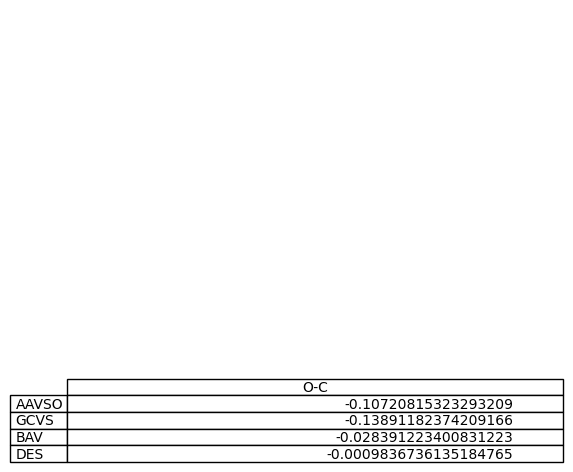

In [94]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, oc)  # where df is your data frame

plt.show()

In [ ]:
pip install astropy

Note: you may need to restart the kernel to use updated packages.
